In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

from spectrum import *
from pylab import *
import scipy.signal as sps

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(30)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.15:41067 Dashboard: http://10.148.1.15:8787/status,Cluster Workers: 40 Cores: 160 Memory: 2000.00 GB


## 1. Slepian window

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:529: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/spectrum/mtm.py:530: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will re

[0, 8460, 0, 0.05]

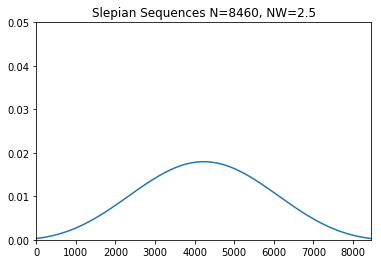

In [31]:
N = 8460
[w, eigens] = dpss(N, 2, 1)
plot(w)
title('Slepian Sequences N=%s, NW=2.5' % N)
axis([0, N, 0, 0.05])

# 2. Rotary spectral

In [6]:
### Here we need to load both SSU and SSV to generate the complex format of horizontal velocoty for rotary spectral calculations, u+iv

v_u = 'SSU'
v_v = 'SSV'

## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

## dir where spectra will be stored
E_dir = '/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/'

print(data_dir)
print(E_dir)

/home1/scratch/xyu/mit_zarr/UV/LLC1080/
/home1/scratch/xyu/mit_spec/zavg_UV/LLC1080/


In [7]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


_______
# 2. Rotary spectra of horizontal velocity

________
## Method 2: An update on xrft

### The latest xrft supports 'time_to_segments', i.e. takes chunks along the dimension of FFT, and divides into segments (length of chunks) automatically, but it might be tricky to do overlapping.

In [8]:
face = 1
time_chunk = 1440
ij_chunk = 108

In [9]:
grid = mgrid.isel(face=face)
    
# Read SSU #
ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
ds_SSU = ds_SSU.chunk(chunks) 
# Read SSV #
ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
ds_SSV = ds_SSV.chunk(chunks) 
# Merge into one xarray dataset #
ds = xr.merge([ds_SSU, ds_SSV, grid])    
print(ds)

<xarray.Dataset>
Dimensions:  (i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    CS       (i, j) float32 ...
    SN       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 1080, 1080), chunksize=(1440, 108, 108)>
    SSV      (time, j, i) float32 dask.array<shape=(8640, 1080, 1080), chunksize=(1440, 108, 108)>


In [15]:
ldv = ds['SSU'].isel(i=slice(0,10), j=slice(0,10)).to_dataset()
print(ldv)

<xarray.Dataset>
Dimensions:  (i: 10, j: 10, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1440,)>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    CS       (i, j) float32 ...
    SN       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 10, 10), chunksize=(1440, 10, 10)>


In [41]:
SSU_detrend = xr.DataArray(sps.detrend(ldv['SSU']), dims=ldv['SSU'].dims, coords=ldv['SSU'].coords)

In [38]:
window = np.hanning(8640)

In [44]:
u_fft = xrft.dft(window*ds['SSU'].fillna(0.), dim=['time'], shift=False, detrend=False, window=False, chunks_to_segments=False)    

ValueError: operands could not be broadcast together with shapes (8640,) (8640, 1080, 1080)

In [10]:
## Here we do DFT on u+iv ##
time_chunk = 1440
ij_chunk = 108

for face in face_all:
    
    # Grid #
    grid = mgrid.isel(face=face)
    
    # Read SSU #
    ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
    ds_SSU = ds_SSU.chunk(chunks) 
    # Read SSV #
    ds_SSV = xr.open_zarr(data_dir+'SSV_f%02d.zarr'%(face)).rename({'j_g': 'j'})
    chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
    ds_SSV = ds_SSV.chunk(chunks) 
    # Merge into one xarray dataset #
    ds = xr.merge([ds_SSU, ds_SSV, grid])    
    #print('\n data size: %.1f GB' %(ds.nbytes / 1e9))
    
    # u+iv
    uv_complex = (ds_SSU['SSU'] + 1j*ds_SSV['SSV'])
    # fft
    uv_fft_complex = xrft.dft(uv_complex.fillna(0.), dim=['time'], shift=False, detrend=False, window=False, chunks_to_segments=True)    
    E_uv_segments = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/time_chunk*3600        
    E_uv = E_uv_segments.mean(dim=['time_segment']) 
    E_uv = np.real(E_uv).rename('E_uv')
    E_uv = xr.merge([E_uv, grid])
    file_E = E_dir+'E_uv_f%02d_1080_slepian.zarr'%face
    %time E_uv.to_zarr(file_E, mode='w')  
    print('face %d done'%face )

CPU times: user 1min 15s, sys: 3.41 s, total: 1min 19s
Wall time: 1min 52s
face 1 done
CPU times: user 1min, sys: 3.17 s, total: 1min 4s
Wall time: 1min 23s
face 2 done
CPU times: user 1min 22s, sys: 3.72 s, total: 1min 26s
Wall time: 2min 1s
face 4 done
CPU times: user 52.3 s, sys: 1.98 s, total: 54.3 s
Wall time: 1min 12s
face 5 done
CPU times: user 1min 22s, sys: 3.48 s, total: 1min 25s
Wall time: 1min 56s
face 7 done
CPU times: user 1min 30s, sys: 4.15 s, total: 1min 34s
Wall time: 2min 15s
face 8 done
CPU times: user 1min 4s, sys: 2.79 s, total: 1min 7s
Wall time: 1min 28s
face 10 done
CPU times: user 1min 22s, sys: 3.39 s, total: 1min 26s
Wall time: 1min 58s
face 11 done
